# $\S$ 2.3. Two Simple Approaches to Prediction: Least Squares and Nearest Neighbors

In this section we develop two simple but powerful prediction methods: The linear model fit by least squares and the $k$-nearest-neighbor (kNN) prediction rule.

The linear model makes huge assumptions about structure and yields stable but possibly inaccurate predictions. The method of kNN makes very mild structural assumptions: Its predictions are often accurate but can be unstable.

## $\S$ 2.3.3 From Least Squares to Nearest Neighbors

The linear decision boundary from least squares is very smooth, and apparently stable to fit. It does appear to rely heavily on the assumption that a linear decision boundary is appropriate. In language we will develop shortly, it has low variance and potentially high bias.

On the other hand, the $k$-nearest-neighbor procedures do not appear to rely on any stringent assumptions about the underlying data, and can adapt to any situation. However, any particular subregion of the decision boundary depends on a handful of input points and their particular positions, and is thus wiggly and unstable—high variance and low bias.

Let's expose the oracle first! The data is generated with following steps:
1. Generate 10 means $m_k$ from a bivariate Gaussian for each class  

  \begin{equation}
  m_k \sim \begin{cases}
  N((1,0)^T, \mathbf{I}) & \text{ for BLUE}, \\
  N((0,1)^T, \mathbf{I}) & \text{ for ORANGE}
  \end{cases}
  \end{equation}
  
2. For each class, we generate 100 observations as follows:
  1. Pick an $m_k$ at random with probability 1/10
  2. Generate $x_i \sim N(m_k, \mathbf{I}/5)$

(To be continued)

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(sample_size:int)->tuple:
    # Parameters for mean distributions
    mean_blue = [1, 0]
    mean_orange = [0, 1]
    mean_cov = np.eye(2)
    mean_size = 10
    
    # Additional parameters for blue and orange distributions
    sample_cov = np.eye(2)/5
    
    # Generate mean components for blue and orange (10 means for each)
    sample_blue_mean = np.random.multivariate_normal(mean_blue, mean_cov, mean_size)
    sample_orange_mean = np.random.multivariate_normal(mean_orange, mean_cov, mean_size)
    
    # Generate blue points
    sample_blue = np.array([
        np.random.multivariate_normal(sample_blue_mean[random.randint(0, 9)],
                                      sample_cov)
        for _ in range(sample_size)
    ])
    y_blue = [0 for _ in range(sample_size)]

    # Generate orange points
    sample_orange = np.array([
        np.random.multivariate_normal(sample_orange_mean[random.randint(0, 9)],
                                      sample_cov)
        for _ in range(sample_size)
    ])
    y_orange = [1 for _ in range(sample_size)]

    data_x = np.concatenate((sample_blue, sample_orange), axis=0)
    data_y = np.concatenate((y_blue, y_orange))
    return data_x, data_y

In [3]:
sample_size = 100
data_x, data_y = generate_data(sample_size)
sample_blue = data_x[data_y == 0, :]
sample_orange = data_x[data_y == 1, :]

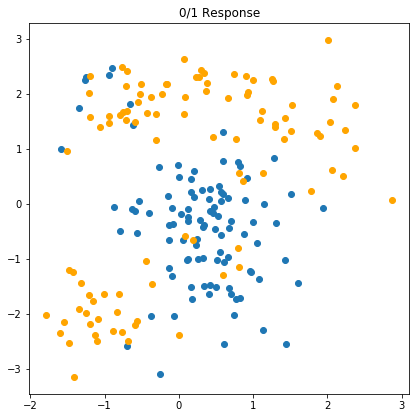

In [4]:
# Plot
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)

ax1.plot(sample_blue[:, 0], sample_blue[:, 1], 'o')
ax1.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax1.set_title('0/1 Response')
plt.show()

plot_x_min, plot_x_max = ax1.get_xlim()
plot_y_min, plot_y_max = ax1.get_ylim()

## $\S$ 2.3.1. Linear Models and Least Squares

> The linear model has been a mainstay of statistics for the past 30 years and remains one of our most important tools.

### Linear Models

Given a vector of inputs $X^T = (X_1, \cdots, X_p)$, we predict the output $Y$ via the model

\begin{equation}
\hat{Y} = \hat{\beta}_0 + \sum^p_{j=1}X_j\hat{\beta}_j = X^T\hat{\beta},
\end{equation}

where the constant variable 1 in $X^T = (1, X_1, \cdots, X_p)$ and $\hat{\beta}^T = (\beta_0, \beta_1, \cdots, \beta_p)$. The term $\hat\beta_0$ is the intercept, a.k.a. the _bias_ in machine learning.

Here we are modeling a single output, so $\hat{Y}$ is a scalar; in general $\hat{Y}$ can be a $K$-vector, in which case $\beta$ would be a $p \times K$ matrix of coefficients.

In the $(p+1)$-dimensional input-output space, $(X, \hat{Y})$ represents a hyperplane. If the constant is included in $X$, then the hyperplane includes the origin and is a subspace; if not, is is an affine set cutting the $Y$-axis at the point $(0, \hat\beta_0)$. From now on we assume that the intercept is included in $\hat\beta$.

Viewed as a function over the $p$-dimensional input space,

\begin{equation}
f(X) = X^T\beta
\end{equation}

is linear, and the gradient $f'(X) = \beta$ is a vector in input space that points in the steepest uphill direction.

### How to fit the model: Least squares

Least squares pick the coefficients $\beta$ to minimize the residual sum of squares

\begin{equation}
RSS(\beta) = \sum^N_{i=1}(y_i - x_i^T\beta)^2 = (\mathbf{y} - \mathbf{X}\beta)^T(\mathbf{y} - \mathbf{X}\beta),
\end{equation}

where $\mathbf{X}$ is an $N \times p$ matrix with each row an input vector, and $\mathbf{y}$ is an $N$-vector of outputs in the training set.

$RSS(\beta)$ is a quadratic function of the parameters, and hence its minimum always exists, but may not be unique.

Differentiating w.r.t. $\beta$ we get the *normal equations*

\begin{equation}
\mathbf{X}^T(\mathbf{y} - \mathbf{X}\beta) = 0.
\end{equation}

If $\mathbf{X}^T \mathbf{X}$ is nonsingular, then the unique solution is given by

\begin{equation}
\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y},
\end{equation}

and the *fitted value* at the $i$th input $x_i$ is 

\begin{equation}
\hat{y}_i = \hat{y}(x_i) = x_i^T\hat{\beta}.
\end{equation}

At an arbitrary input $x_0$ the prediction is

\begin{equation}
\hat{y}(x_0) = x_0^T \hat\beta.
\end{equation}

The entire fitted surface is characterized by the $p$ parameters. Intuitively, it seems that we do not need a very large data set to fit such a model.

In [5]:
# Linear regression
mat_x = np.hstack((np.ones((sample_size*2, 1)), data_x))
mat_xt = np.transpose(mat_x)
vec_y = data_y

# Solve (X^T*X)b = X^T*y for b
ols_beta = np.linalg.solve(np.matmul(mat_xt, mat_x), np.matmul(mat_xt, vec_y))

print('=== Estimated Coefficients for OLS ===')
print('beta0:', ols_beta[0], '(constant)')
print('beta1:', ols_beta[1])
print('beta2:', ols_beta[2])

=== Estimated Coefficients for OLS ===
beta0: 0.5055893971801289 (constant)
beta1: -0.08695186862409199
beta2: 0.11063600407467852


### Linear model in a classification context

FIGURE 2.1 shows a scatterplot of training data on a pair of inputs $X_1$ and $X_2$.
* The output class variable $G$ has the values $\textsf{BLUE}$ or $\textsf{ORANGE}$.
* There are 100 points in each of the two classes.
* The linear regression model was fit to these data, with the response $Y$ coded as $0$ for $\textsf{BLUE}$ and $1$ for $\textsf{ORANGE}$.

The fitted value $\hat{Y}$ are converted to a fitted class variable $\hat{G}$ according to the rule

\begin{equation}
\hat{G} = \begin{cases}
1 & \text{ (ORANGE) } & \text{ if } \hat{Y} \gt 0.5,\\
0 & \text{ (BLUE) } & \text{ if } \hat{Y} \le 0.5.
\end{cases}
\end{equation}

And the two predicted classes are separated by the *decision boundary* $\{x: x^T\hat{\beta} = 0.5\}$, which in linear.

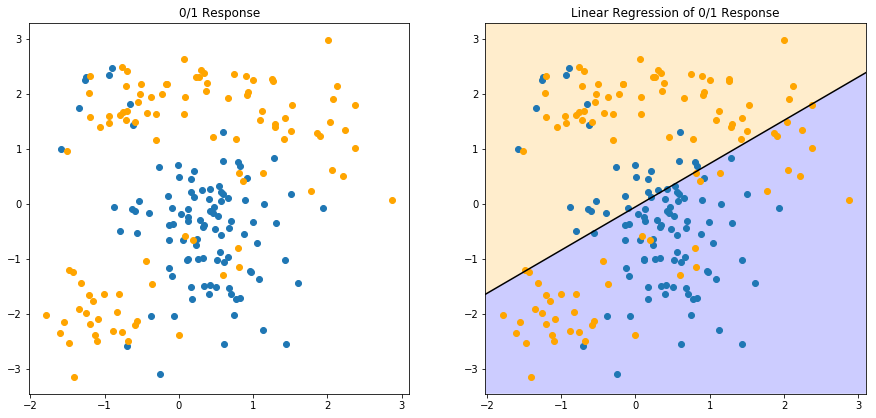

In [6]:
"""FIGURE 2.1. A classification example in 2D."""
# Plot for OLS
ax2 = fig.add_subplot(2, 2, 2)

ax2.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax2.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')

# OLS line for y_hat = 0.5
ols_line_y_min = (.5 - ols_beta[0] - plot_x_min*ols_beta[1])/ols_beta[2]
ols_line_y_max = (.5 - ols_beta[0] - plot_x_max*ols_beta[1])/ols_beta[2]
ax2.plot([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], color='black')

# https://matplotlib.org/examples/pylab_examples/fill_between_demo.html
ax2.fill_between([plot_x_min, plot_x_max], plot_y_min, [ols_line_y_min, ols_line_y_max],
                facecolor='blue', alpha=.2)
ax2.fill_between([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], plot_y_max,
                facecolor='orange', alpha=.2)
ax2.set_title('Linear Regression of 0/1 Response')
ax2.set_xlim((plot_x_min, plot_x_max))
ax2.set_ylim((plot_y_min, plot_y_max))
fig

### Where the data came from?

We see that for these data there are several misclassifications on both sides of the decision boundary. Perhaps our linear model is too rigid -- or are such errors unavoidable? Remember that these are errors on the training data itself, and we have not said where the constructed came from (although this notebook already exposed the oracle). Consider the two possible scenarios:
* $\text{Scenario 1}$: The training data in each class were generated from bivariate Gaussian distributions with uncorrelated components and different means.
* $\text{Scenario 2}$: The training data in each class came from a mixture of 10 low-variance Gaussian distributions, with individual means themselves distributed as Gaussian.

A mixture of Gaussians is best described in terms of the generative model.
* One first generates a discrete variable that determines which of the component Gaussians to use,
* and then generates an observation from the chosen density.

In the case of one Gaussian per class, we will see in Chapter 4 that a linear decision boundary is the best one can do, and that our estimate is almost optimal. The region of overlap is inevitable, and future data to be predicted will be plagued by this overlap as well.

## $\S$ 2.3.2 Nearest-Neighbor Methods

Now we look at another classification and regression procedure that is in some sense at the opposite end of the spectrum to the linear model, and far better suited to the second scenario.

> Nearest-neighbor methods use those observations in the training set $\mathcal{T}$ closest in input space to $x$ to form $\hat{Y}$.

The kNN fit for $\hat{Y}$ is defined as follows:

\begin{equation}
\hat{Y}(x) = \frac{1}{k}\sum_{x_i\in N_k(x)} y_i,
\end{equation}

where $N_k(x)$ is the neighborhood of $x$ defined by the $k$ closest points $x_i$ in the training sample. Closeness implies a metric, which for the moment we assume is Euclidean distance.

> So, in other words, we find the $k$ observations with $x_i$ closest to $x$ in input space, and average their responses.

In FIGURE 2.2 we use the same training data, and use 15NN averaging of the binary coded response as the method of fitting. Thus $\hat{Y}$ is the proportion of $\textsf{ORANGE}$s in the neighborhood, and so assigning class $\text{ORANGE}$ to $\hat{G}$ if $\hat{Y} > 0.5$ amounts to a majority vote in the neighborhood.

We see that the decision boundaries that separate the $\textsf{BLUE}$ from the $\textsf{ORANGE}$ regions are far more irregular, and respond to local clusters where one class dominates.

In [7]:
# K-nearest neighbors
def knn(k: int, point, data_x, data_y) -> float:
    if not isinstance(point, np.ndarray):
        point = np.array(point)
    distances = [(sum((x - point)**2), y) for x, y in zip(data_x, data_y)]
    distances.sort()
    return sum(y for _, y in distances[:k])/k

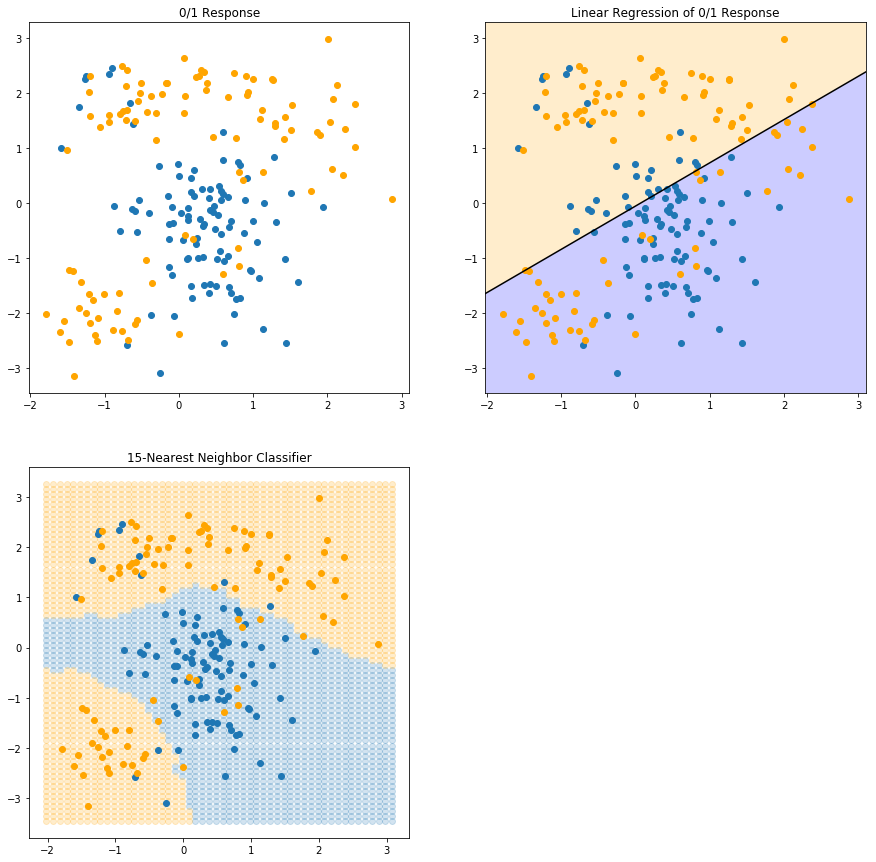

In [8]:
"""FIGURE 2.2. 15-nearest-neighbor method"""
# Compute KNN for k = 15 and k = 1
knn_grid = np.array([(i, j)
                     for i in np.arange(plot_x_min, plot_x_max, .1)
                     for j in np.arange(plot_y_min, plot_y_max, .1)])
knn15_result = np.array([
    (i, j, knn(15, (i, j), data_x, vec_y))
    for i, j in knn_grid
])

# Plot for KNN with k = 15
knn15_blue = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 < .5
])
knn15_orange = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 > .5
])
ax3 = fig.add_subplot(2, 2, 3)
# KNN areas
ax3.plot(knn15_blue[:, 0], knn15_blue[:, 1], 'o', alpha=.2)
ax3.plot(knn15_orange[:, 0], knn15_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax3.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax3.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax3.set_title('15-Nearest Neighbor Classifier')
fig

FIGURE 2.3 shows the results for 1NN classification: $\hat{Y} is assigned the value $y_l$ of the closest point $x_l$ to $x$ in the training data. In this case the regions of classification can be computed relatively easily, and correspond to a _Voronoi tessellation_ of the training data. 

The decision boundary is even more irregular than before.

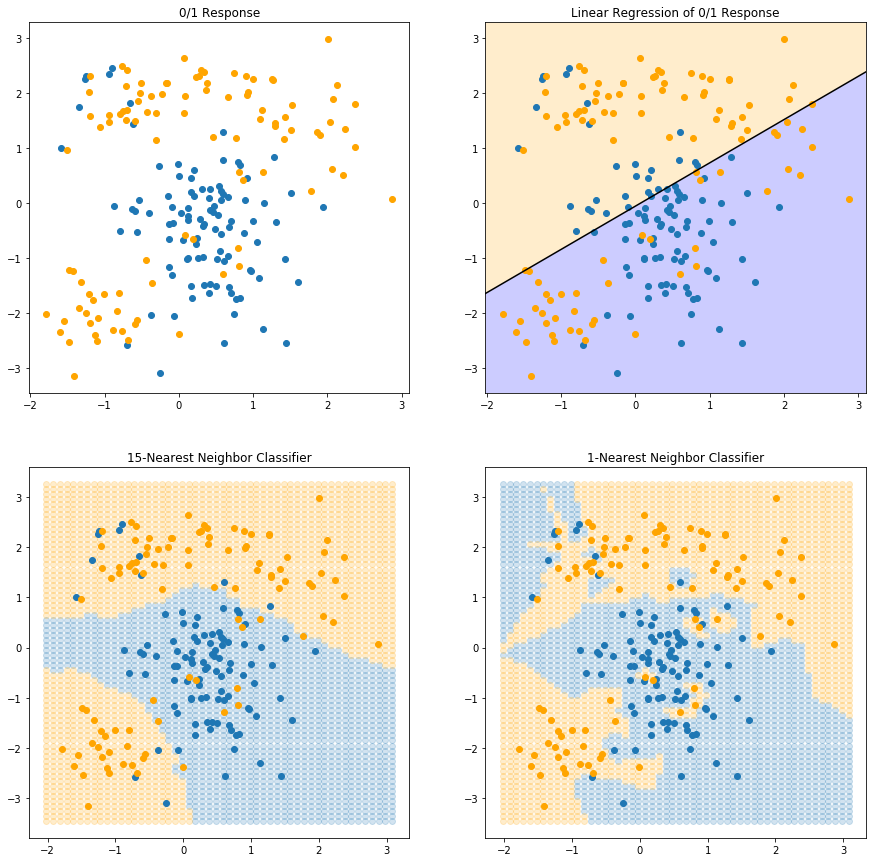

In [9]:
"""FIGURE 2.3. 1-nearest-neighbor method"""
# Compute KNN for k = 15 and k = 1
knn1_result = np.array([
    (i, j, knn(1, (i, j), data_x, vec_y))
    for i, j in knn_grid
])

knn1_blue = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 < .5
])
knn1_orange = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 > .5
])

# Plot for KNN with k = 1
ax4 = fig.add_subplot(2, 2, 4)
# KNN areas
ax4.plot(knn1_blue[:, 0], knn1_blue[:, 1], 'o', alpha=.2)
ax4.plot(knn1_orange[:, 0], knn1_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax4.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax4.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax4.set_title('1-Nearest Neighbor Classifier')
fig

The method of kNN averaging is defined in exactly the same way for regression of a quantitative output $Y$, although $k=1$ would be an unlikely choice.

### Do not satisfy with the training results

With 15NN, We see that far fewer training observations are misclassfied than the linear model fit. This should not give us too much comfort, though, since using 1NN  _none_ of the training data are misclassified.

A little thought suggests that for kNN fits, the error on the training data should be approximately an increasing function of $k$, and will always be 0 for $k=1$.

An independent test set would give us a more satisfactory means for comparing the different methods.

### Effective number of parameters

It appears that kNN fits have a single parameter, the number of neighbors $k$, compared to the $p$ parameters in least-squares fit. Although this is the case, we will see that the _effective_ number of parameters of kNN is $N/k$ and is generally bigger than $p$, and decreases with increasing $k$.

To get an idea of why, note that if the neighborhoods were nonoverlapping, there would be $N/k$ neighborhoods and we fit one parameter (a mean) in each neighborhood.

### Do not appreciate the training errors

It is also clear that we cannot use sum-of-squared errors on the training set as a criterion for picking $k$, since we would always pick $k=1$! It would seem that kNN methods would be more appropriate for the mixture Scenario 2, while for Scenario 1 the decision boundaries for kNN would be unnecessarily noisy.

## $\S$ 2.3.3. From Least Squares to Nearest Neighbors (continued)

A large subset of the most popular techniques in use today are variants of these two simple procedures. In facti 1NN, the simplest of all, captures a large percentage of the market for low-dimensional problems.

The following list describes some ways in which these simple procedures have been enhanced:
* Kernel methods use weights that decrease smoothly to zero with distance from the target point, rather than the effectve 0/1 weights used by kNN.
* In high-dimensional spaces the distance kernels are modified to emphasize some variable more than others.
* Local regression fits linear models by locally weighted least squares, rather than fitting constants locally.
* Linear models fit to a basis expansion of the original inputs allow arbitrarilly complex models.
* Projection pursuit and neural network models consist of sums of nonlinearly transfromed linear models.